In [316]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sb

import binary_formation_distribution_V8 as myscript
import NT_disk_Eqns_V1 as jscript
import pagn.constants as ct



In [ ]:
filename = "EMRIs_Jupiter/SG/alpha_0.01/EMRIs_G23_Ng_1000_events.txt"

In [332]:
with open(filename) as f:
    lines = f.readlines()

header_end = lines.index("Data:\n") + 1

data = pd.read_csv(filename, delimiter=" ", skiprows=header_end)

data.columns = [col.strip().replace(",", "") for col in data.columns]
print(data.keys())

N=len(data["m1/Msun"])
print(f'Columns: {header_end}, Rows: {N}')


Index(['logMBH/Msun', 'm1/Msun', 'r0/Rg', 'chi_eff', 'T/Myr', 't_gw/Myr',
       't_migr/Myr', 'is_emri', 'Ng', 'R_final/Rg', 'lisa_radii/Rg',
       'lisa_flag', 'final_flag'],
      dtype='object')
Columns: 11, Rows: 1000


In [333]:
# for i in range (0, len(data['lisa_flag'])):
#     if data['lisa_flag'][i]==0:
#         print(f'event {i} does not enter LISA band before T_disk')


H0 = 70 * 1000 * ct.yr / (1e6 * ct.pc) #km s^-s Mpc_^-1
t0 = 1.0/H0 
print(t0/1e6)

for i in range (0, N):
    if data['is_emri'][i]==0:
        t_gw=data['t_gw/Myr'][i]
        t_m=data['t_migr/Myr'][i]
        if (min(t_m, t_gw) < t0)==False:
            print(f'event {i} will not inspiral before T_disc, and will not inspiral within t0')

13969.91985629905


In [154]:
weird_events=[]
identified_EMRIS=[]

for i in range(0, len(data.is_emri)):
    MBH=10**data['logMBH/Msun'][i]
    m1=data['m1/Msun'][i]

    spin=(data['chi_eff'][i]+1)/2

    lisa_flag=data['lisa_flag'][i]
    lisa_radii=data['lisa_radii/Rg'][i]

    final_radii=data["R_final/Rg"][i]

    R_diff=lisa_radii-final_radii

    if lisa_flag!=0 and data.is_emri[i]==True:
        # print(f'EMRI {i} with SMBH {MBH:.3e} MSun, SBH {m1:.3e} MSun, SMBH spin {spin:.3} enters LISA band at {lisa_radii:.3} R_G')
        if R_diff>0:
            print(f'EMRI {i} enters LISA band at {lisa_radii:.3} R_G \n At t=T_disc, R_final={final_radii} R_G')
            identified_EMRIS.append(i)
        if R_diff<0:
            print(f'SOMETHING WRONG WITH EMRI {i}, R_DIFF={R_diff} R_g')
    if lisa_flag==0 and data.is_emri[i]==True:
        weird_events.append(i)
    # if lisa_flag!=0 and data.is_emri[i]==False:
    #     # print(f'"Dried" EMRI {i} with SMBH {MBH/ct.MSun:.3e} MSun, SBH {m1/ct.MSun:.3e} MSun, SMBH spin {spin:.3} enters LISA band at {lisa_radii:.3} R_G')
    #     print(f'"Dried" EMRI {i} enters LISA band at {lisa_radii:.3} R_G after t=T_disk')
    # else:
    #     print(f'EMRI {i} doesnt enter LISA band before t=T_disk')

print(weird_events)
print(identified_EMRIS)

EMRI 2 enters LISA band at 18.1 R_G 
 At t=T_disc, R_final=17.67 R_G
EMRI 5 enters LISA band at 16.5 R_G 
 At t=T_disc, R_final=15.33 R_G
EMRI 6 enters LISA band at 10.4 R_G 
 At t=T_disc, R_final=10.36 R_G
EMRI 14 enters LISA band at 25.7 R_G 
 At t=T_disc, R_final=7.562 R_G
EMRI 20 enters LISA band at 19.9 R_G 
 At t=T_disc, R_final=19.49 R_G
EMRI 24 enters LISA band at 43.3 R_G 
 At t=T_disc, R_final=34.32 R_G
EMRI 31 enters LISA band at 30.9 R_G 
 At t=T_disc, R_final=30.7 R_G
EMRI 34 enters LISA band at 6.53 R_G 
 At t=T_disc, R_final=6.518 R_G
EMRI 38 enters LISA band at 28.0 R_G 
 At t=T_disc, R_final=27.61 R_G
EMRI 39 enters LISA band at 9.52 R_G 
 At t=T_disc, R_final=9.515 R_G
EMRI 43 enters LISA band at 7.46 R_G 
 At t=T_disc, R_final=0.4491 R_G
EMRI 44 enters LISA band at 7.0 R_G 
 At t=T_disc, R_final=6.988 R_G
EMRI 50 enters LISA band at 22.0 R_G 
 At t=T_disc, R_final=21.62 R_G
EMRI 52 enters LISA band at 39.4 R_G 
 At t=T_disc, R_final=38.52 R_G
EMRI 55 enters LISA band

In [155]:
events= weird_events
#events=identified_EMRIS

for k in range (0, len(events)):
    i=events[k]
    MBH=10**data['logMBH/Msun'][i]
    m1=data['m1/Msun'][i]

    spin=(data['chi_eff'][i]+1)/2

    lisa_flag=data['lisa_flag'][i]
    lisa_radii=data['lisa_radii/Rg'][i]

    final_radii=data["R_final/Rg"][i]

    rG=ct.G*MBH*(1/(ct.c*ct.c))

    print(f'EMRI {events[k]} enters LISA band at {lisa_radii} R_G, final radii within t=T_disk is {final_radii} R_G')

EMRI 0 enters LISA band at 0.0 R_G, final radii within t=T_disk is 41.8 R_G
EMRI 10 enters LISA band at 0.0 R_G, final radii within t=T_disk is 28.82 R_G
EMRI 11 enters LISA band at 0.0 R_G, final radii within t=T_disk is 44.11 R_G
EMRI 15 enters LISA band at 0.0 R_G, final radii within t=T_disk is 39.52 R_G
EMRI 17 enters LISA band at 0.0 R_G, final radii within t=T_disk is 51.3 R_G
EMRI 22 enters LISA band at 0.0 R_G, final radii within t=T_disk is 45.94 R_G
EMRI 28 enters LISA band at 0.0 R_G, final radii within t=T_disk is 40.58 R_G
EMRI 37 enters LISA band at 0.0 R_G, final radii within t=T_disk is 47.4 R_G
EMRI 41 enters LISA band at 0.0 R_G, final radii within t=T_disk is 59.21 R_G
EMRI 46 enters LISA band at 0.0 R_G, final radii within t=T_disk is 38.58 R_G
EMRI 47 enters LISA band at 0.0 R_G, final radii within t=T_disk is 47.77 R_G
EMRI 65 enters LISA band at 0.0 R_G, final radii within t=T_disk is 15.57 R_G
EMRI 69 enters LISA band at 0.0 R_G, final radii within t=T_disk is 

In [162]:
for i in range(0, len(weird_events)):
    k=weird_events[i]
    print(f'\nEvent {k} ')
    for key in data.keys():
        print(f'{key}: {data[key][k]}')


Event 0 
logMBH/Msun: 7.3
m1/Msun: 20.7
r0/Rg: 44.01
chi_eff: -0.2952
T/Myr: 5.873
t_gw/Myr: 0.2179
t_migr/Myr: 210.5
is_emri: True
Ng: 1
R_final/Rg: 41.8
lisa_radii/Rg: 0.0
lisa_flag: 0
final_flag: 2

Event 10 
logMBH/Msun: 6.9
m1/Msun: 19.22
r0/Rg: 29.1
chi_eff: -0.02325
T/Myr: 1.718
t_gw/Myr: 0.00878
t_migr/Myr: 345.2
is_emri: True
Ng: 1
R_final/Rg: 28.82
lisa_radii/Rg: 0.0
lisa_flag: 0
final_flag: 2

Event 11 
logMBH/Msun: 6.7
m1/Msun: 10.25
r0/Rg: 45.44
chi_eff: 0.2938
T/Myr: 1.563
t_gw/Myr: 0.03113
t_migr/Myr: 100.5
is_emri: True
Ng: 1
R_final/Rg: 44.11
lisa_radii/Rg: 0.0
lisa_flag: 0
final_flag: 2

Event 15 
logMBH/Msun: 7.0
m1/Msun: 9.555
r0/Rg: 42.9
chi_eff: -0.4183
T/Myr: 10.78
t_gw/Myr: 0.09258
t_migr/Myr: 230.8
is_emri: True
Ng: 1
R_final/Rg: 39.52
lisa_radii/Rg: 0.0
lisa_flag: 0
final_flag: 2

Event 17 
logMBH/Msun: 7.0
m1/Msun: 7.429
r0/Rg: 198.0
chi_eff: -0.1143
T/Myr: 30.67
t_gw/Myr: 78.05
t_migr/Myr: 4.266
is_emri: True
Ng: 1
R_final/Rg: 51.3
lisa_radii/Rg: 0.0
lisa_f

In [37]:
MBH=1e6*ct.MSun
m1=10*ct.MSun

rG=ct.G*MBH*(1/(ct.c*ct.c))
Rs = 2*rG

r0=1e4*Rs
Rmin=50*Rs

lisa_flag, lisa_radii=jscript.LISAband_flag(r0, Rmin, MBH, m1)

if lisa_flag!=0:
    print(f'EMRI with SMBH {MBH/ct.MSun:.3e} MSun, SBH {m1/ct.MSun:.3e} MSun enters LISA band at {lisa_radii/rG:.3e} R_G')
elif lisa_flag==0:
    print(f'EMRI doesnt enter LISA band')

EMRI doesnt enter LISA band


In [210]:
groups=data.groupby("final_flag", as_index=True)
labels= "no inspiral or detection", "detected, no inspiral", "inspiral, no detection", "inspirals and detected"

for k in range(0, groups.ngroups):
    group=groups.get_group(k)["r0/Rg"]
    print(labels[k], group)


no inspiral or detection 1     2600.00
3       91.02
4     1235.00
8      202.90
9       73.86
12     143.40
16    1084.00
19     540.00
21     142.10
23     270.00
26     117.50
27    6375.00
29     185.90
30     147.20
32     246.70
35     196.80
36     405.30
42     194.90
45      78.73
48      92.47
49     202.10
51      68.48
53      85.77
54      67.06
56     620.40
57     541.10
59     235.40
66     304.00
67     139.70
71     204.10
72    1741.00
75    2139.00
77     162.80
83     404.50
86     485.20
89     238.50
95     164.60
97    1006.00
Name: r0/Rg, dtype: float64
detected, no inspiral 7     57.34
33    81.78
40    76.30
60    58.84
Name: r0/Rg, dtype: float64
inspiral, no detection 0      44.010
10     29.100
11     45.440
15     42.900
17    198.000
22     48.740
28     41.540
37     62.170
41     67.870
46     44.300
47     52.170
65     15.570
69      8.339
74     17.900
78     79.270
79     30.060
80     67.710
82     57.550
88     76.670
96     14.160
Name: r0/Rg, d

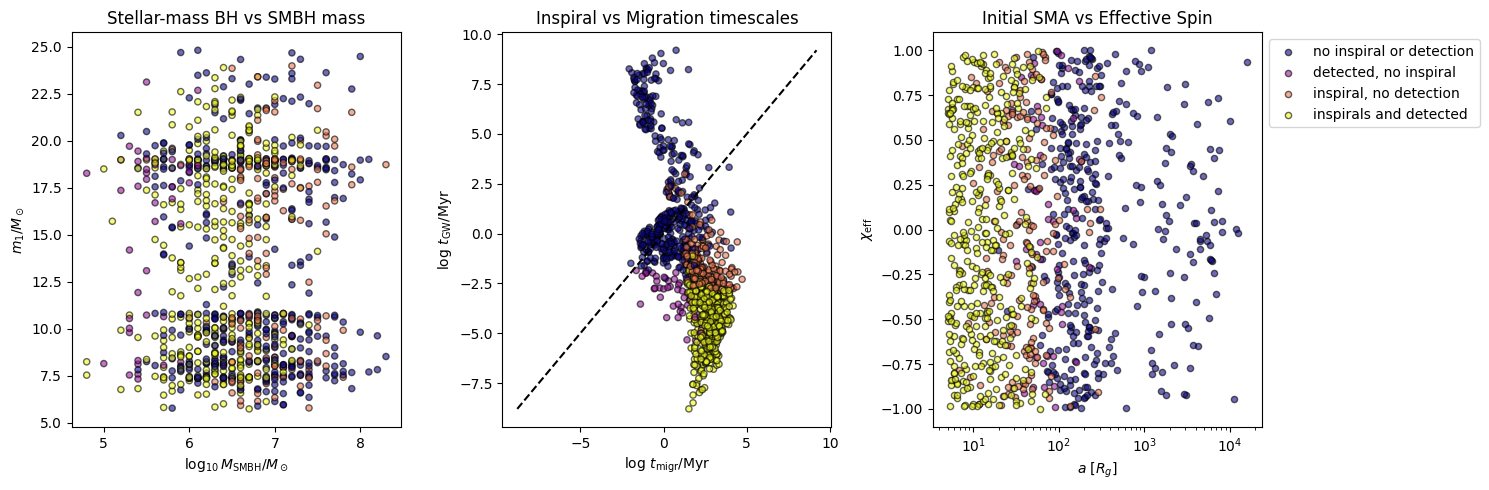

In [294]:
colour='plasma'

dir='flagged_EMRIs'
N=len(data["m1/Msun"])

fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

groups=data.groupby("final_flag", as_index=True)
labels= "no inspiral or detection", "detected, no inspiral", "inspiral, no detection", "inspirals and detected"

i=0
sc1 = axs[i].scatter(data["logMBH/Msun"], data["m1/Msun"], c=data['final_flag'], cmap=colour, alpha=0.6, edgecolor='k', s=20)
axs[i].set_xlabel(r'$\log_{10} M_{\rm SMBH} / M_\odot$')
axs[i].set_ylabel(r'$m_1 / M_\odot$')
axs[i].set_title('Stellar-mass BH vs SMBH mass')

i=1
t_migr = np.log10(data["t_migr/Myr"])
t_gw = np.log10(data["t_gw/Myr"])
sc2 = axs[i].scatter(t_migr, t_gw, c=data["final_flag"], cmap=colour, alpha=0.6, edgecolor='k', s=20)
axs[i].plot([min(t_gw.min(), t_migr.min()), max(t_gw.max(), t_migr.max())],
            [min(t_gw.min(), t_migr.min()), max(t_gw.max(), t_migr.max())],
            'k--', label=r'$t_{\rm GW} = t_{\rm migr}$')

axs[i].set_xlabel(r'log $t_{\rm migr}$/Myr')
axs[i].set_ylabel(r'log $t_{\rm GW}$/Myr')
axs[i].set_title('Inspiral vs Migration timescales')

i=2
cmap = plt.colormaps[colour]
colors_map = {0: cmap(0.), 1: cmap(1.0/3), 2: cmap(2.0/3), 3: cmap(1.)}
for k in range(0, groups.ngroups):
    # axs[i].scatter(group["r0/Rg"], group["chi_eff"], color=colors_map[label],
    #             label="detected by LISA" if label else "not detected by LISA" else "inspirals" else "does not inspiral",
    #             s=20, alpha=0.6, edgecolor="k")
    axs[i].scatter(groups.get_group(k)["r0/Rg"], groups.get_group(k)["chi_eff"], color=colors_map[k],
                   label=labels[k],
                   s=20, alpha=0.6, edgecolor="k")
axs[i].set_xlabel(r'$a$ [$R_g$]')
axs[i].set_xscale('log')
axs[i].set_ylabel(r'$\chi_{\rm eff}$')
axs[i].set_title('Initial SMA vs Effective Spin')
# axs[i].legend()
axs[i].legend(bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig(f'{dir}/summary_{N}.pdf')
plt.show()

In [295]:
# Function to make 1 scatter + marginal histograms
def plot_with_marginals(fig, data, x, y, is_emri, xlabel, ylabel, title, logx=False, logy=False):
    g = sb.jointplot(
        data=data,
        x=x, y=y,
        hue=is_emri,
        palette=colors_map,
        alpha=0.5
    )

    g.figure.suptitle(title, y=1.02)
    g.set_axis_labels(xlabel, ylabel)

    if logx:
        g.ax_joint.set_xscale('log')
        g.ax_marg_x.set_xscale('log')
    if logy:
        g.ax_joint.set_yscale('log')
        g.ax_marg_y.set_yscale('log')




<Figure size 600x600 with 0 Axes>

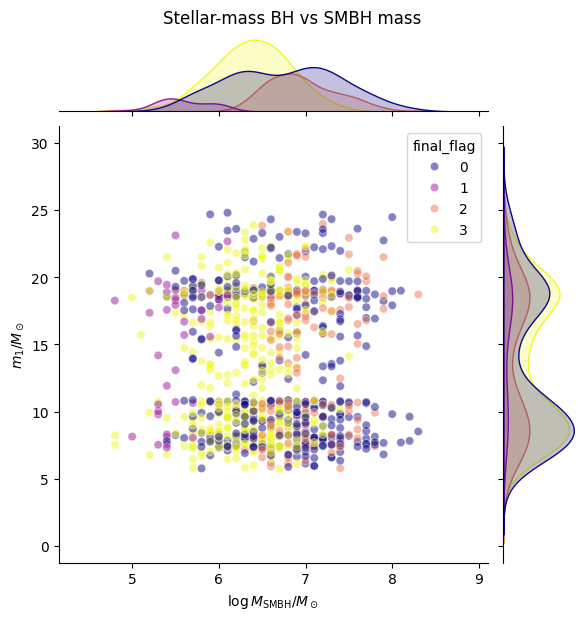

In [296]:
fig = plt.figure(figsize=(6, 6))


# Plot 1: m1 vs logMBH
plot_with_marginals(
    fig, data,
    x="logMBH/Msun",
    y="m1/Msun",
    is_emri="final_flag",
    xlabel=r'$\log M_{\rm SMBH} / M_\odot$',
    ylabel=r'$m_1 / M_\odot$',
    title='Stellar-mass BH vs SMBH mass'
)

fig.tight_layout()
plt.savefig(f'{dir}/masses_{N}.pdf')
plt.show()

<Figure size 600x600 with 0 Axes>

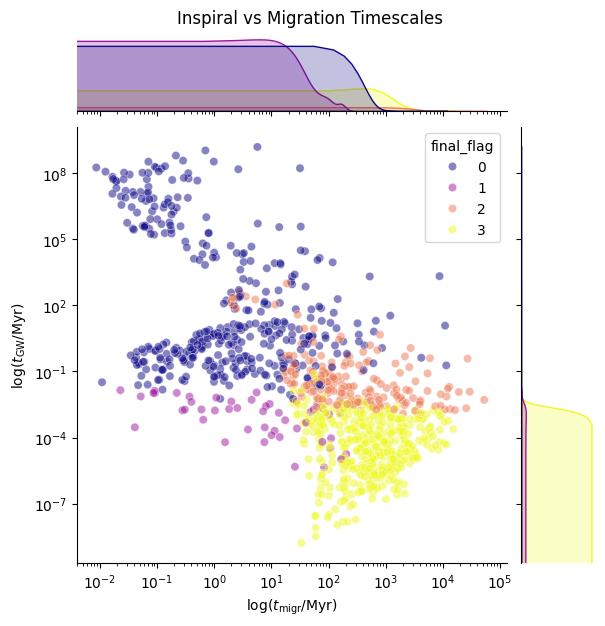

In [297]:
fig = plt.figure(figsize=(6, 6))

# Plot 2: log t_migr vs log t_gw
plot_with_marginals(
    fig, data,
    x="t_migr/Myr",
    y="t_gw/Myr",
    is_emri="final_flag",
    xlabel=r'$\log (t_{\rm migr} / \mathrm{Myr})$',
    ylabel=r'$\log (t_{\rm GW} / \mathrm{Myr})$',
    title='Inspiral vs Migration Timescales',
    logx=True,
    logy=True
)


fig.tight_layout()
plt.savefig(f'{dir}/timescales_{N}.pdf')
plt.show()

<Figure size 600x600 with 0 Axes>

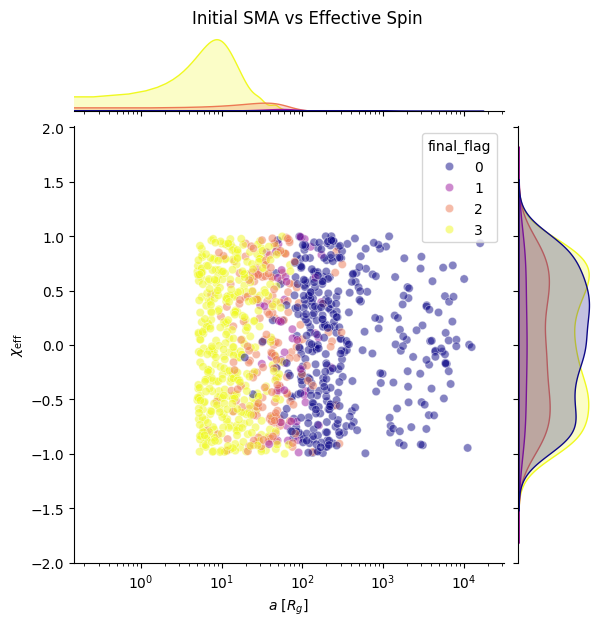

In [298]:
fig = plt.figure(figsize=(6, 6))

# Plot 3: r0 vs chi_eff
plot_with_marginals(
    fig, data,
    x="r0/Rg",
    y="chi_eff",
    is_emri="final_flag",
    xlabel=r'$a$ [$R_g$]',
    ylabel=r'$\chi_{\rm eff}$',
    title='Initial SMA vs Effective Spin',
    logx=True,
    logy=False
)


fig.tight_layout()
plt.savefig(f'{dir}/sma_chieff_{N}.pdf')
plt.show()